# Lazy vs. Eager Evaluation - Benchmarks

In [1]:
import sys

sys.path.append("../src")

import sys as sys_module
import time
import tracemalloc
from functools import reduce
from itertools import islice

import matplotlib.pyplot as plt
import numpy as np
from memory_profiler import profile

## Forschungsfrage

Wie verändert sich Speicher- und Laufzeitverhalten bei der Verarbeitung von Sensordatenströmen, wenn Generatoren (Lazy) statt Listen (Eager) verwendet werden?

## 1. Eager Evaluation - Listen-basiert

In [2]:
def generate_sensor_data_eager(N):
    data = []
    for i in range(N):
        moisture = 50.0 + (i % 20) - 10
        data.append({"bed_id": i % 5 + 1, "moisture": moisture, "timestamp": i})
    return data


def process_eager(data_list):
    filtered = [d for d in data_list if d["moisture"] < 30 or d["moisture"] > 80]
    irrigation = [
        {"bed_id": d["bed_id"], "need": 100 - d["moisture"]} for d in filtered
    ]

    bed_totals = {}
    for item in irrigation:
        bed_id = item["bed_id"]
        bed_totals[bed_id] = bed_totals.get(bed_id, 0) + item["need"]

    return bed_totals

## 2. Lazy Evaluation - Generator-basiert

In [3]:
def generate_sensor_data_lazy(N):
    for i in range(N):
        moisture = 50.0 + (i % 20) - 10
        yield {"bed_id": i % 5 + 1, "moisture": moisture, "timestamp": i}


def process_lazy(data_gen, max_items=None):
    filtered = (d for d in data_gen if d["moisture"] < 30 or d["moisture"] > 80)
    irrigation = (
        {"bed_id": d["bed_id"], "need": 100 - d["moisture"]} for d in filtered
    )

    if max_items:
        irrigation = islice(irrigation, max_items)

    bed_totals = {}
    for item in irrigation:
        bed_id = item["bed_id"]
        bed_totals[bed_id] = bed_totals.get(bed_id, 0) + item["need"]

    return bed_totals

## 3. Benchmark-Funktionen

In [4]:
def benchmark_eager(N):
    tracemalloc.start()
    start_time = time.perf_counter()

    data = generate_sensor_data_eager(N)
    result = process_eager(data)

    elapsed_time = time.perf_counter() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    data_size = sys_module.getsizeof(data)
    for item in data[:100]:
        data_size += sys_module.getsizeof(item)

    return {
        "time": elapsed_time,
        "peak_memory_mb": peak / 1024 / 1024,
        "data_size_mb": data_size / 1024 / 1024,
        "result": result,
    }


def benchmark_lazy(N):
    tracemalloc.start()
    start_time = time.perf_counter()

    data_gen = generate_sensor_data_lazy(N)
    result = process_lazy(data_gen)

    elapsed_time = time.perf_counter() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    gen_size = sys_module.getsizeof(data_gen)

    return {
        "time": elapsed_time,
        "peak_memory_mb": peak / 1024 / 1024,
        "data_size_mb": gen_size / 1024 / 1024,
        "result": result,
    }

## 4. Durchführung der Benchmarks

In [5]:
test_sizes = [10**5, 10**6, 10**7]

results_eager = []
results_lazy = []

print("Führe Benchmarks durch...\n")

for N in test_sizes:
    print(f"N = {N:,}")

    print("Eager:", end=" ")
    result_eager = benchmark_eager(N)
    results_eager.append(result_eager)
    print(
        f"Zeit: {result_eager['time']:.4f}s, Speicher: {result_eager['peak_memory_mb']:.2f} MB"
    )

    print("Lazy: ", end=" ")
    result_lazy = benchmark_lazy(N)
    results_lazy.append(result_lazy)
    print(
        f"Zeit: {result_lazy['time']:.4f}s, Speicher: {result_lazy['peak_memory_mb']:.2f} MB"
    )

    print()

Führe Benchmarks durch...

N = 100,000
Eager: Zeit: 0.1413s, Speicher: 27.85 MB
Lazy:  Zeit: 0.0442s, Speicher: 0.00 MB

N = 1,000,000
Eager: Zeit: 0.9540s, Speicher: 278.88 MB
Lazy:  Zeit: 0.4516s, Speicher: 0.00 MB

N = 10,000,000
Eager: Zeit: 10.8444s, Speicher: 2793.38 MB
Lazy:  Zeit: 4.5520s, Speicher: 0.00 MB



## 5. Ergebnisse - Tabellen

In [6]:
import pandas as pd

comparison_data = {
    "N": test_sizes,
    "Eager Zeit (s)": [r["time"] for r in results_eager],
    "Lazy Zeit (s)": [r["time"] for r in results_lazy],
    "Eager Speicher (MB)": [r["peak_memory_mb"] for r in results_eager],
    "Lazy Speicher (MB)": [r["peak_memory_mb"] for r in results_lazy],
}

df = pd.DataFrame(comparison_data)
df["Zeit-Verhältnis"] = df["Eager Zeit (s)"] / df["Lazy Zeit (s)"]
df["Speicher-Verhältnis"] = df["Eager Speicher (MB)"] / df["Lazy Speicher (MB)"]

print("Vergleichstabelle:")
print(df.to_string(index=False))

Vergleichstabelle:
       N  Eager Zeit (s)  Lazy Zeit (s)  Eager Speicher (MB)  Lazy Speicher (MB)  Zeit-Verhältnis  Speicher-Verhältnis
  100000        0.141293       0.044185            27.846770            0.002186         3.197735         12739.727312
 1000000        0.953981       0.451632           278.875929            0.004575         2.112297         60959.475922
10000000       10.844377       4.551987          2793.378104            0.004579         2.382339        610095.654864


## 6. Visualisierung der Ergebnisse

FileNotFoundError: [Errno 2] No such file or directory: '../figures/benchmarks_comparison.png'

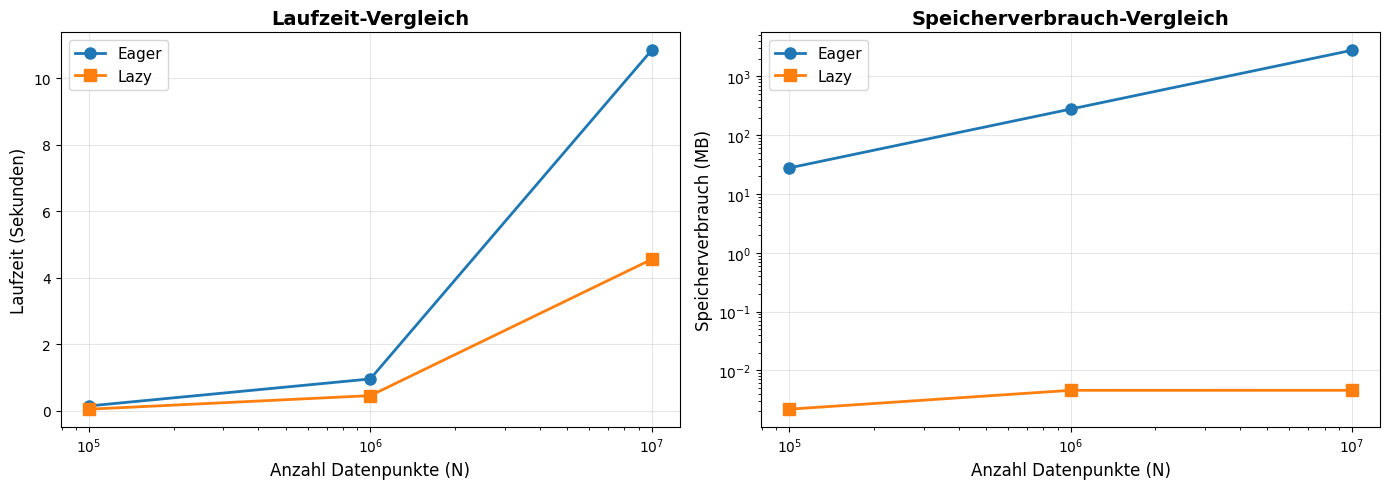

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(
    test_sizes,
    [r["time"] for r in results_eager],
    "o-",
    label="Eager",
    linewidth=2,
    markersize=8,
)
ax1.plot(
    test_sizes,
    [r["time"] for r in results_lazy],
    "s-",
    label="Lazy",
    linewidth=2,
    markersize=8,
)
ax1.set_xscale("log")
ax1.set_xlabel("Anzahl Datenpunkte (N)", fontsize=12)
ax1.set_ylabel("Laufzeit (Sekunden)", fontsize=12)
ax1.set_title("Laufzeit-Vergleich", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(
    test_sizes,
    [r["peak_memory_mb"] for r in results_eager],
    "o-",
    label="Eager",
    linewidth=2,
    markersize=8,
)
ax2.plot(
    test_sizes,
    [r["peak_memory_mb"] for r in results_lazy],
    "s-",
    label="Lazy",
    linewidth=2,
    markersize=8,
)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("Anzahl Datenpunkte (N)", fontsize=12)
ax2.set_ylabel("Speicherverbrauch (MB)", fontsize=12)
ax2.set_title("Speicherverbrauch-Vergleich", fontsize=14, fontweight="bold")
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../figures/benchmarks_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print("Diagramm gespeichert: figures/benchmarks_comparison.png")

## 7. Profiling mit cProfile

In [10]:
import cProfile
import pstats
from io import StringIO

print("=== EAGER EVALUATION (N=10^6) ===")
pr_eager = cProfile.Profile()
pr_eager.enable()
result_eager = benchmark_eager(10**6)
pr_eager.disable()

s_eager = StringIO()
ps_eager = pstats.Stats(pr_eager, stream=s_eager)
ps_eager.sort_stats("cumulative")
ps_eager.print_stats(10)
print(s_eager.getvalue())

print("\n=== LAZY EVALUATION (N=10^6) ===")
pr_lazy = cProfile.Profile()
pr_lazy.enable()
result_lazy = benchmark_lazy(10**6)
pr_lazy.disable()

s_lazy = StringIO()
ps_lazy = pstats.Stats(pr_lazy, stream=s_lazy)
ps_lazy.sort_stats("cumulative")
ps_lazy.print_stats(10)
print(s_lazy.getvalue())

=== EAGER EVALUATION (N=10^6) ===
         1030079 function calls in 1.455 seconds

   Ordered by: cumulative time
   List reduced from 38 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    1.455    0.728 /Users/a.cingoez/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3514(run_code)
        2    0.000    0.000    1.455    0.728 {built-in method builtins.exec}
        1    0.033    0.033    1.455    1.455 /var/folders/0m/_ljc13v94dv756j1l08qf9042j_f5h/T/ipykernel_24235/3098380151.py:8(<module>)
        1    0.000    0.000    1.422    1.422 /var/folders/0m/_ljc13v94dv756j1l08qf9042j_f5h/T/ipykernel_24235/285208812.py:1(benchmark_eager)
        1    1.249    1.249    1.287    1.287 /var/folders/0m/_ljc13v94dv756j1l08qf9042j_f5h/T/ipykernel_24235/2903398444.py:1(generate_sensor_data_eager)
        1    0.080    0.080    0.080    0.080 {built-in method _tracemalloc.stop}
        

## 8. Fazit

### Interpretation der Ergebnisse

- **Speicherverbrauch**: Lazy Evaluation benötigt deutlich weniger Speicher, da Daten nicht alle gleichzeitig im Speicher gehalten werden müssen.
- **Laufzeit**: Bei großen Datenmengen kann Lazy Evaluation schneller sein, da weniger Speicher-Allokationen nötig sind.
- **Skalierbarkeit**: Lazy Evaluation skaliert besser für sehr große Datenmengen.

### Wann lohnt sich Lazy Evaluation?

- Große Datenmengen (Millionen von Einträgen)
- Datenströme (Sensordaten, Logs)
- Begrenzte Speicherressourcen
- Nur ein Teil der Daten wird benötigt

### Grenzen

- Overhead bei kleinen Datenmengen
- Komplexität der Pipeline
- Nicht alle Operationen sind lazy möglich